In [1]:
from fbpinns.problems import Problem
import jax.numpy as jnp
import jax

class WaveEquation2D(Problem):
    """Solves the time-dependent 1D viscous Burgers equation
        d^2 u       d^2 u    
        ----- - c^2 ----- = 0
        d t^2       d x^2    

        for (x, t) in [0, 1]^2

        Boundary conditions:
        u(0, t) = 0
        u(1, t) = 0
        u(x, 0) = sin(πx) + 0.5 sin(4πx)
        u_t(x, 0) = 0
    """

    @staticmethod
    def init_params(c=jnp.sqrt(2), sd=0.1):

        static_params = {
            "dims":(1,2),
            "c":c,
            "sd":sd,
            }
        
        return static_params, {}

    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):

        # physics loss
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        required_ujs_phys = (
            (0,(0,0)),
            (0,(1,1)),
        )
        return [[x_batch_phys, required_ujs_phys],]


    @staticmethod
    def constraining_fn(all_params, x_batch, u):
        sd = all_params["static"]["problem"]["sd"]
        x, t, tanh, sin, pi = x_batch[:,0:1], x_batch[:,1:2], jax.nn.tanh, jnp.sin, jnp.pi
        u = tanh(x/sd) * tanh((1-x)/sd) * t**2 * u  + (sin(pi*x) + 0.5 * sin(4*pi*x))
        return u

    @staticmethod
    def loss_fn(all_params, constraints):
        c = all_params["static"]["problem"]["c"]
        _, uxx, utt = constraints[0]
        phys = utt - c**2 * uxx
        mse = jnp.mean(phys**2)
        return mse, phys
    
    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape):

        c = all_params["static"]["problem"]["c"]
        x, t, sin, cos, pi = x_batch[:,0:1], x_batch[:,1:2], jnp.sin, jnp.cos, jnp.pi
        u = sin(pi*x)*cos(c*pi*t) + 0.5 * sin(4*pi*x)*cos(4*c*pi*t)
        return u

class WaveEquation2DAttn(WaveEquation2D):
    @staticmethod
    def loss_fn(all_params, constraints):
        c = all_params["static"]["problem"]["c"]
        _, uxx, utt = constraints[0]
        phys = utt - c**2 * uxx

        selected = all_params["trainable"]["problem"]["selected"]
        alpha = all_params["trainable"]["attention"]["alpha"][selected.astype(jnp.int32)]  # (N,1)
        alpha_detached = jax.lax.stop_gradient(alpha)
        loss = jnp.mean((alpha_detached[:, None] * phys)**2)
        return loss, phys


[INFO] 2025-06-07 15:49:24 - <fbpinns.constants.Constants object at 0x7d8a9b6962d0>
run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([0., 0.]), 'xmax': array([1., 1.])}
problem: <class '__main__.WaveEquation2D'>
problem_init_kwargs: {'c': 2}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([0.  , 0.25, 0.5 , 0.75, 1.  ]), array([0.  , 0.25, 0.5 , 0.75, 1.  ])], 'subdomain_ws': [array([0.725, 0.725, 0.725, 0.725, 0.725]), array([0.725, 0.725, 0.725, 0.725, 0.725])], 'unnorm': (0.0, 3.0)}
network: <class 'fbpinns.networks.StackedJacobiKAN_'>
network_init_kwargs: {'dims': [2, 4, 1], 'degrees': [4, 4]}
n_steps: 25000
scheduler: <class 'fbpinns.schedulers.AllActiveSchedulerND'>
scheduler_kwargs: {}
ns: ((200, 200),)
n_test: (200, 200)
sampler: grid
optimiser: <function adam at 0x7d8b5fadce00>
optimiser_kwargs: {'learning_rate': 0.001}
seed: 0
summary_freq: 1000
test

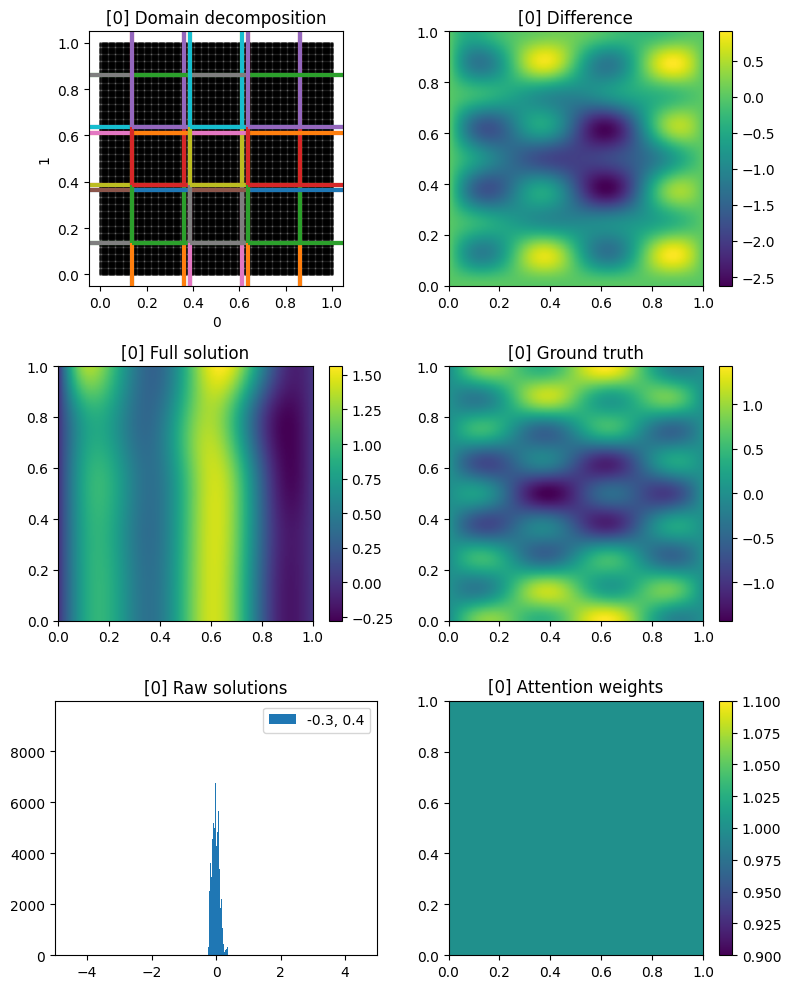

[INFO] 2025-06-07 15:50:17 - [i: 1000/25000] loss: 394.2035 rate: 20.1 elapsed: 0.01 hr test
[INFO] 2025-06-07 15:51:02 - [i: 2000/25000] loss: 194.1819 rate: 22.3 elapsed: 0.03 hr test
[INFO] 2025-06-07 15:51:47 - [i: 3000/25000] loss: 55.1828 rate: 22.3 elapsed: 0.04 hr test
[INFO] 2025-06-07 15:52:32 - [i: 4000/25000] loss: 14.1563 rate: 22.2 elapsed: 0.05 hr test
[INFO] 2025-06-07 15:53:17 - [i: 5000/25000] loss: 8.2509 rate: 22.2 elapsed: 0.06 hr test
[INFO] 2025-06-07 15:53:18 - saved arrays


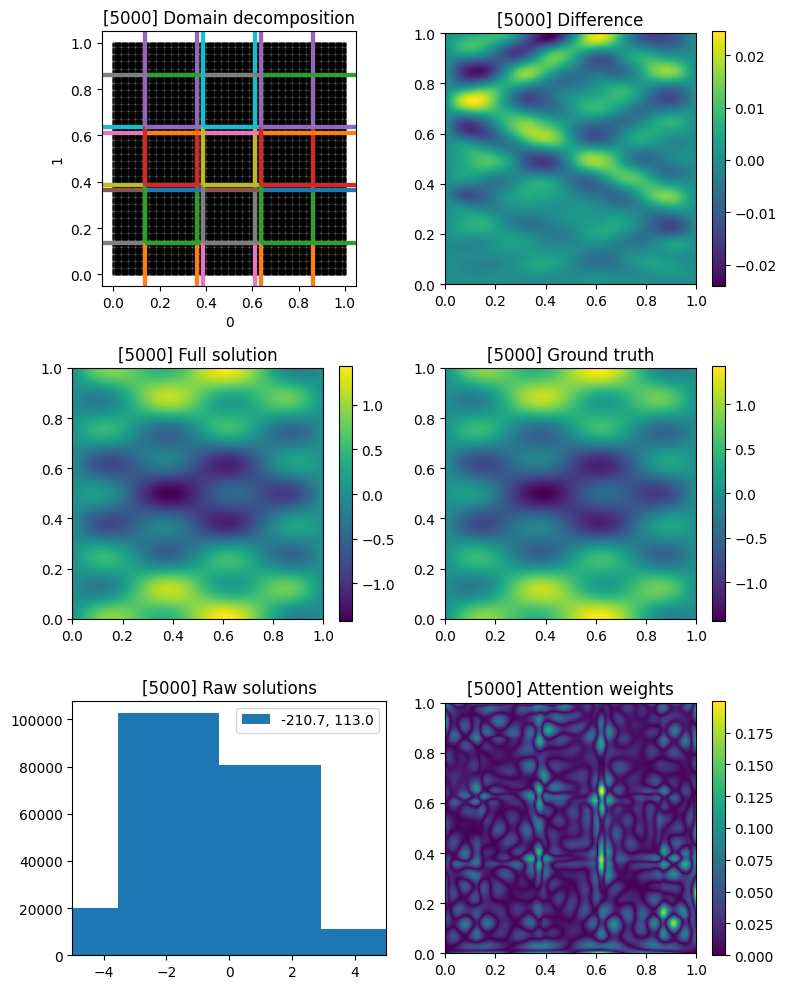

[INFO] 2025-06-07 15:54:04 - [i: 6000/25000] loss: 5.7726 rate: 22.2 elapsed: 0.08 hr test
[INFO] 2025-06-07 15:54:49 - [i: 7000/25000] loss: 4.8527 rate: 22.2 elapsed: 0.09 hr test
[INFO] 2025-06-07 15:55:34 - [i: 8000/25000] loss: 3.6742 rate: 22.2 elapsed: 0.10 hr test
[INFO] 2025-06-07 15:56:19 - [i: 9000/25000] loss: 3.1190 rate: 22.2 elapsed: 0.11 hr test
[INFO] 2025-06-07 15:57:04 - [i: 10000/25000] loss: 2.7311 rate: 22.2 elapsed: 0.13 hr test
[INFO] 2025-06-07 15:57:05 - saved arrays


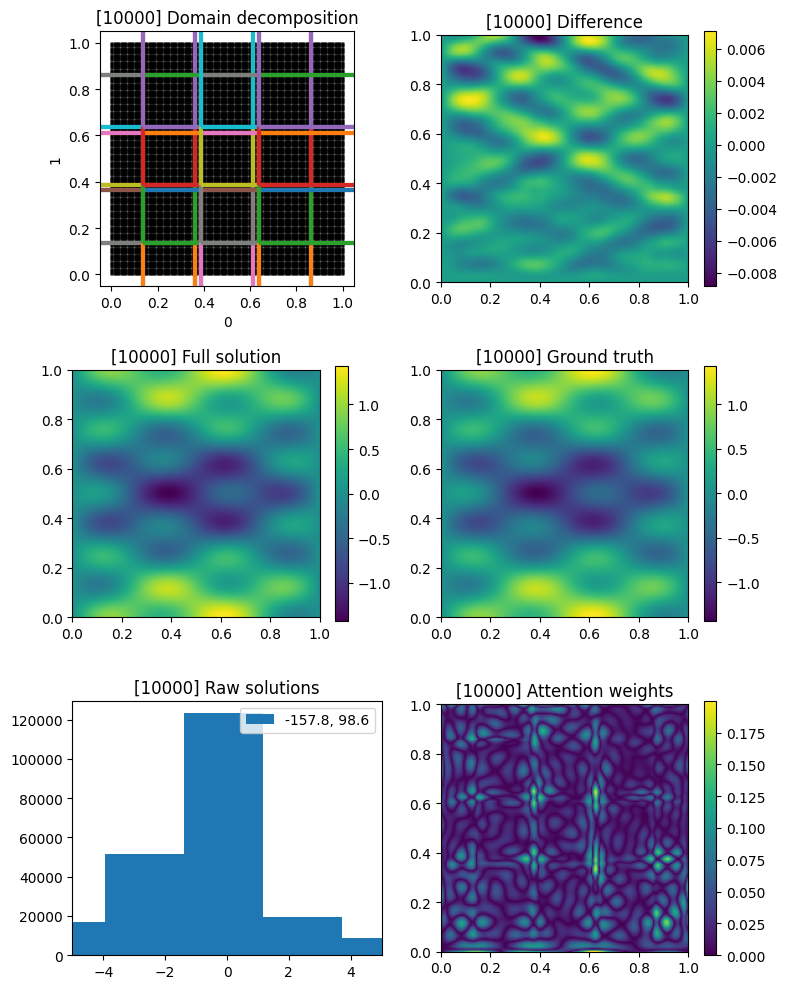

[INFO] 2025-06-07 15:57:51 - [i: 11000/25000] loss: 2.4473 rate: 22.2 elapsed: 0.14 hr test
[INFO] 2025-06-07 15:58:36 - [i: 12000/25000] loss: 2.2102 rate: 22.2 elapsed: 0.15 hr test
[INFO] 2025-06-07 15:59:21 - [i: 13000/25000] loss: 2.0170 rate: 22.2 elapsed: 0.17 hr test
[INFO] 2025-06-07 16:00:06 - [i: 14000/25000] loss: 1.9270 rate: 22.2 elapsed: 0.18 hr test
[INFO] 2025-06-07 16:00:51 - [i: 15000/25000] loss: 1.7221 rate: 22.2 elapsed: 0.19 hr test
[INFO] 2025-06-07 16:00:52 - saved arrays


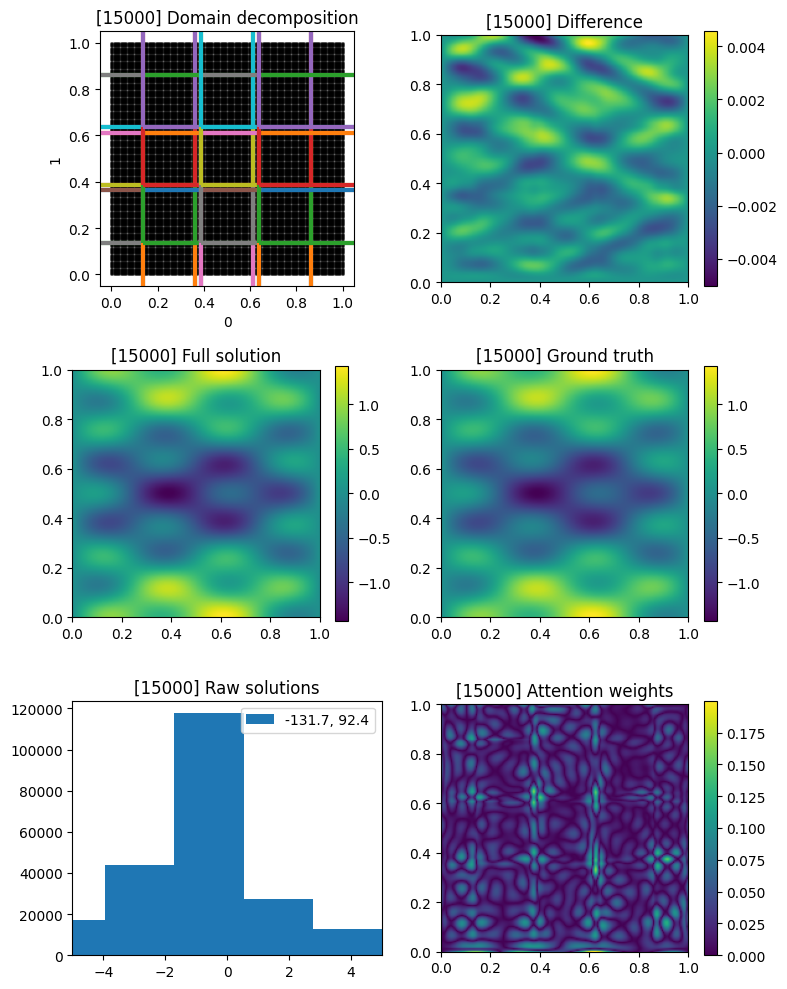

[INFO] 2025-06-07 16:01:38 - [i: 16000/25000] loss: 1.6052 rate: 22.3 elapsed: 0.20 hr test
[INFO] 2025-06-07 16:02:22 - [i: 17000/25000] loss: 1.4931 rate: 22.3 elapsed: 0.22 hr test
[INFO] 2025-06-07 16:03:08 - [i: 18000/25000] loss: 1.4016 rate: 22.2 elapsed: 0.23 hr test
[INFO] 2025-06-07 16:03:53 - [i: 19000/25000] loss: 1.9059 rate: 22.2 elapsed: 0.24 hr test
[INFO] 2025-06-07 16:04:38 - [i: 20000/25000] loss: 1.2447 rate: 22.3 elapsed: 0.25 hr test
[INFO] 2025-06-07 16:04:38 - saved arrays


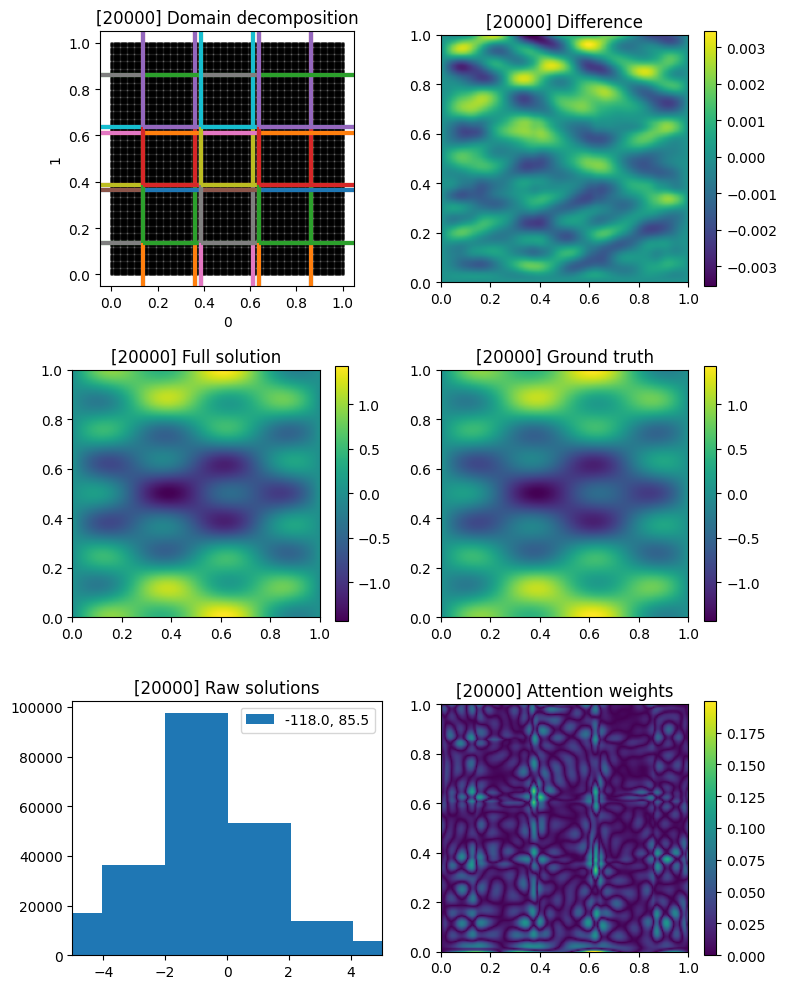

[INFO] 2025-06-07 16:05:24 - [i: 21000/25000] loss: 1.1856 rate: 22.3 elapsed: 0.27 hr test
[INFO] 2025-06-07 16:06:09 - [i: 22000/25000] loss: 1.1167 rate: 22.3 elapsed: 0.28 hr test
[INFO] 2025-06-07 16:06:54 - [i: 23000/25000] loss: 1.2421 rate: 22.3 elapsed: 0.29 hr test
[INFO] 2025-06-07 16:07:39 - [i: 24000/25000] loss: 1.0103 rate: 22.3 elapsed: 0.30 hr test
[INFO] 2025-06-07 16:08:24 - [i: 25000/25000] loss: 0.9681 rate: 22.3 elapsed: 0.32 hr test
[INFO] 2025-06-07 16:08:24 - saved arrays


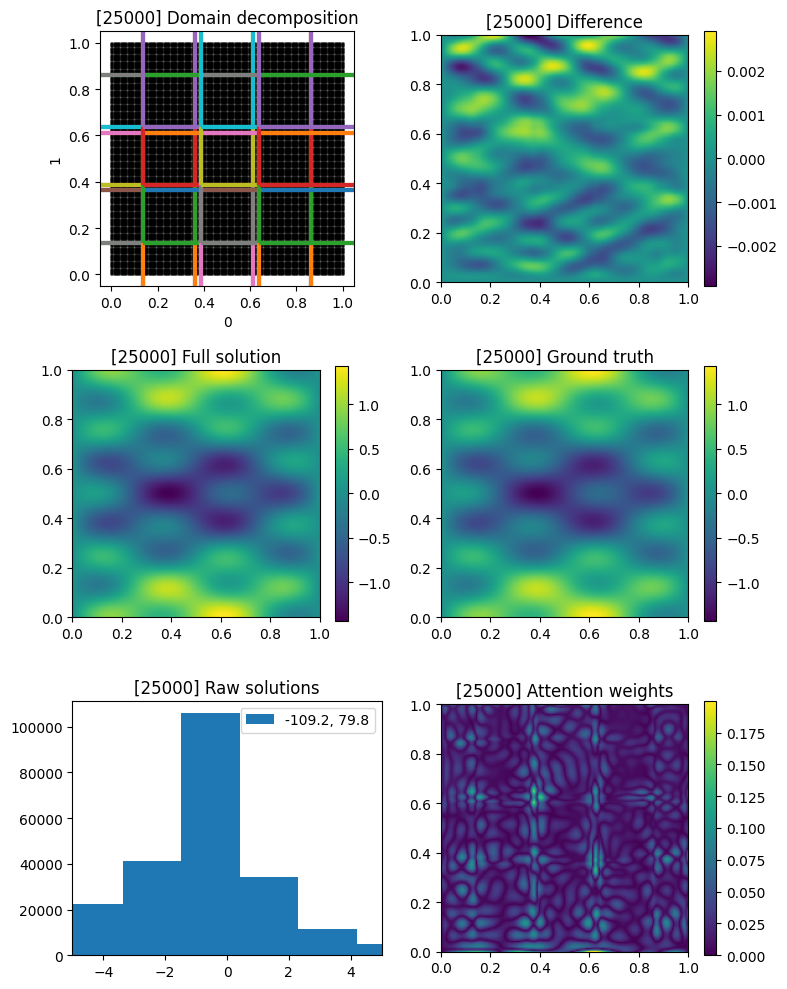

[INFO] 2025-06-07 16:08:25 - [i: 25000/25000] Training complete
[INFO] 2025-06-07 16:08:25 - [i: 25000/25000] Total training time: 1140.10 s


In [6]:
import numpy as np

from fbpinns.domains import RectangularDomainND
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN, OptimizedChebyshevKAN, ChebyshevAdaptiveKAN, OptimizedStackedChebyshevKAN, StackedChebyshevKAN_, StackedJacobiKAN_
from fbpinns.schedulers import LineSchedulerRectangularND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer
from fbpinns.attention import RBAttention

subdomain_xs=[np.linspace(0,1,5), np.linspace(0,1,5)]
c = Constants(
    domain=RectangularDomainND,
    domain_init_kwargs = dict(
        xmin=np.array([0.,0.]),
        xmax=np.array([1.,1.])
        ),
    problem=WaveEquation2D,
    problem_init_kwargs = dict(
        c=2
    ),
    decomposition=RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        subdomain_xs=subdomain_xs,
        subdomain_ws=get_subdomain_ws(subdomain_xs, 2.9),
        unnorm=(0.,3.),
    ),
    # network=FCN,
    # network_init_kwargs = dict(
    #     layer_sizes = (2, 16, 16, 1),
    # ),
    network=StackedJacobiKAN_,
    network_init_kwargs=dict(
        dims=[2, 4, 1],
        degrees=[4, 4],
    ),
    # network_init_kwargs=dict(
    #     in_dim=2,
    #     out_dim=1,
    #     degree=6
    # ),
    # scheduler = LineSchedulerRectangularND,
    # scheduler_kwargs = dict(
    #     point=[0.], iaxis=0,
    # ),
    optimiser_kwargs = dict(
        learning_rate=0.001
        ),
    ns=((200,200),),
    n_test=(200,200),
    n_steps=25000,
    clear_output=False,
    attention_tracker=RBAttention,
    attention_tracking_kwargs=dict(
        eta_lr = 1e-2,
        gamma_decay = 0.95,
        shape=(40000, 1)
        ),
    )

run = FBPINNTrainer(c)
all_params = run.train()

[Errno 16] Device or resource busy: 'results/summaries/test/.nfs00000000664197030000006e'
[INFO] 2025-06-07 16:44:34 - <fbpinns.constants.Constants object at 0x7d8a98babda0>
run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([0., 0.]), 'xmax': array([1., 1.])}
problem: <class '__main__.WaveEquation2DAttn'>
problem_init_kwargs: {'c': 2}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([0.  , 0.25, 0.5 , 0.75, 1.  ]), array([0.  , 0.25, 0.5 , 0.75, 1.  ])], 'subdomain_ws': [array([0.725, 0.725, 0.725, 0.725, 0.725]), array([0.725, 0.725, 0.725, 0.725, 0.725])], 'unnorm': (0.0, 3.0)}
network: <class 'fbpinns.networks.StackedJacobiKAN_'>
network_init_kwargs: {'dims': [2, 3, 1], 'degrees': [4, 4]}
n_steps: 25000
scheduler: <class 'fbpinns.schedulers.AllActiveSchedulerND'>
scheduler_kwargs: {}
ns: ((200, 200),)
n_test: (200, 200)
sampler: grid
optimiser: <function adam

[INFO] 2025-06-07 16:44:34 - x_batch
[INFO] 2025-06-07 16:44:34 - (40000, 2), float32, JVPTracer
[INFO] 2025-06-07 16:44:34 - x_take
[INFO] 2025-06-07 16:44:34 - (285156, 2), float32, JVPTracer
[INFO] 2025-06-07 16:44:38 - [i: 0/25000] Compiling done (4.50 s)
[INFO] 2025-06-07 16:44:38 - p, f
[INFO] 2025-06-07 16:44:38 - (1125, 10393119744.0)
[INFO] 2025-06-07 16:44:39 - saved arrays


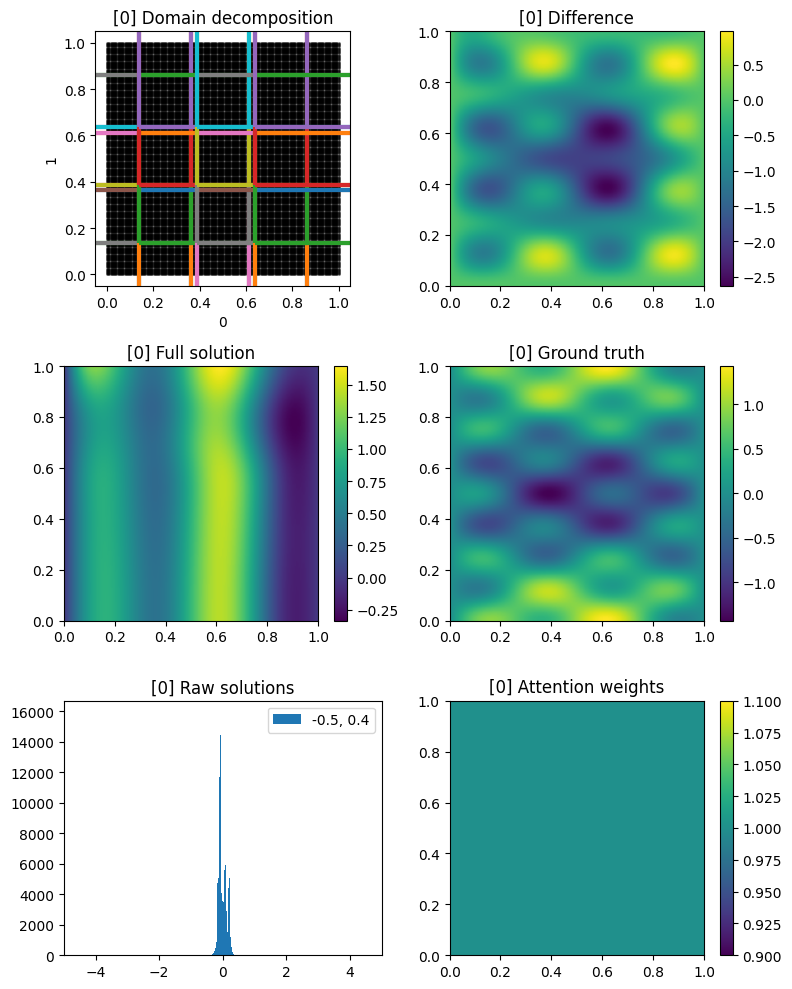

[INFO] 2025-06-07 16:45:58 - [i: 1000/25000] loss: 20.0176 rate: 12.2 elapsed: 0.02 hr test
[INFO] 2025-06-07 16:47:15 - [i: 2000/25000] loss: 2.3417 rate: 12.9 elapsed: 0.04 hr test
[INFO] 2025-06-07 16:48:33 - [i: 3000/25000] loss: 1.1531 rate: 12.9 elapsed: 0.07 hr test
[INFO] 2025-06-07 16:49:50 - [i: 4000/25000] loss: 0.6309 rate: 12.9 elapsed: 0.09 hr test
[INFO] 2025-06-07 16:51:08 - [i: 5000/25000] loss: 0.4414 rate: 12.9 elapsed: 0.11 hr test
[INFO] 2025-06-07 16:51:09 - saved arrays


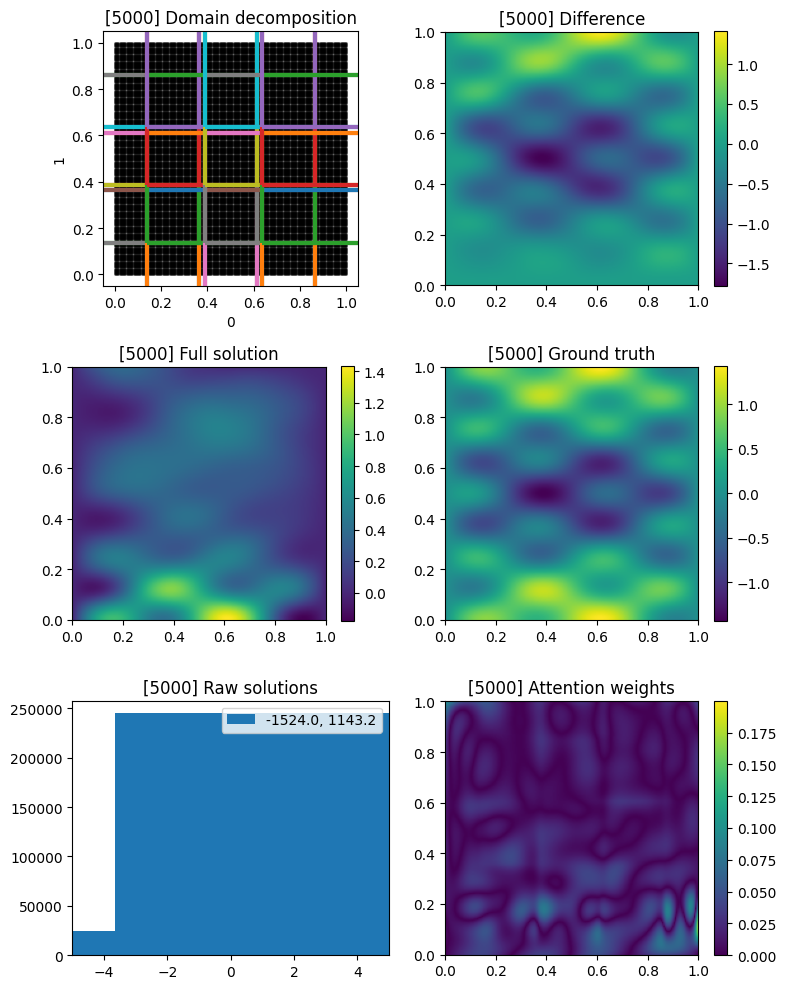

[INFO] 2025-06-07 16:52:27 - [i: 6000/25000] loss: 0.3416 rate: 12.9 elapsed: 0.13 hr test
[INFO] 2025-06-07 16:53:45 - [i: 7000/25000] loss: 0.2798 rate: 12.9 elapsed: 0.15 hr test
[INFO] 2025-06-07 16:55:02 - [i: 8000/25000] loss: 0.2274 rate: 12.9 elapsed: 0.17 hr test
[INFO] 2025-06-07 16:56:20 - [i: 9000/25000] loss: 0.2162 rate: 12.9 elapsed: 0.20 hr test
[INFO] 2025-06-07 16:57:38 - [i: 10000/25000] loss: 0.3130 rate: 12.9 elapsed: 0.22 hr test
[INFO] 2025-06-07 16:57:38 - saved arrays


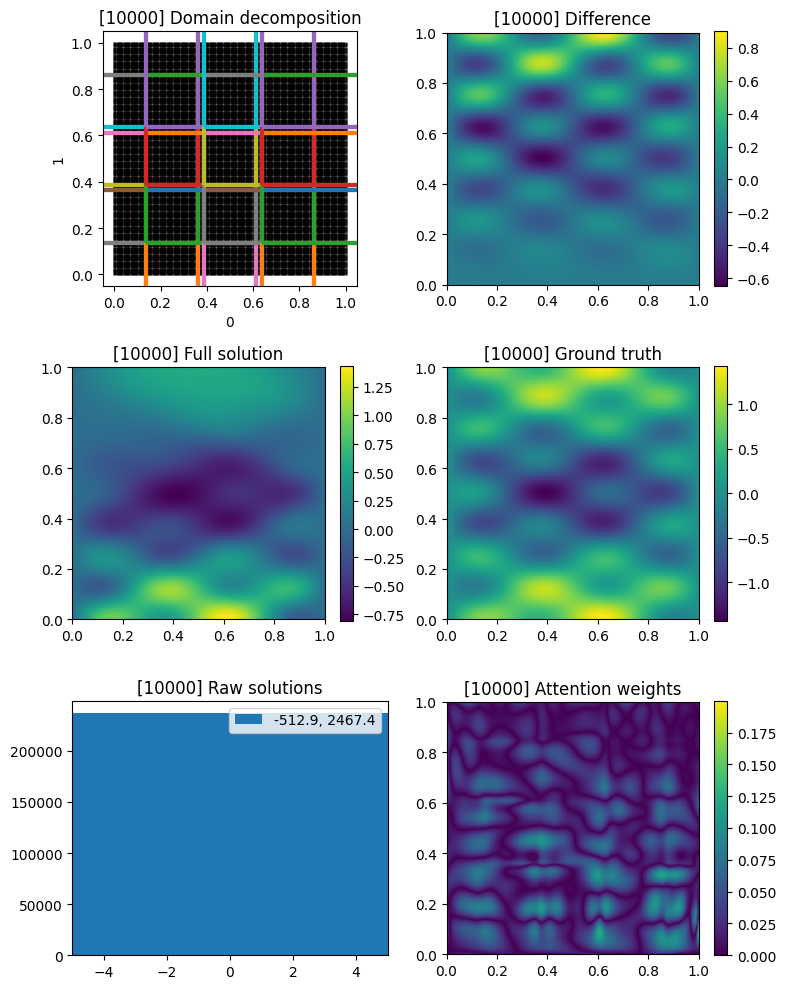

[INFO] 2025-06-07 16:58:57 - [i: 11000/25000] loss: 0.2538 rate: 12.9 elapsed: 0.24 hr test
[INFO] 2025-06-07 17:00:14 - [i: 12000/25000] loss: 0.1026 rate: 12.9 elapsed: 0.26 hr test
[INFO] 2025-06-07 17:01:32 - [i: 13000/25000] loss: 0.0361 rate: 12.9 elapsed: 0.28 hr test
[INFO] 2025-06-07 17:02:49 - [i: 14000/25000] loss: 0.0142 rate: 12.9 elapsed: 0.30 hr test
[INFO] 2025-06-07 17:04:07 - [i: 15000/25000] loss: 0.0067 rate: 12.9 elapsed: 0.33 hr test
[INFO] 2025-06-07 17:04:07 - saved arrays


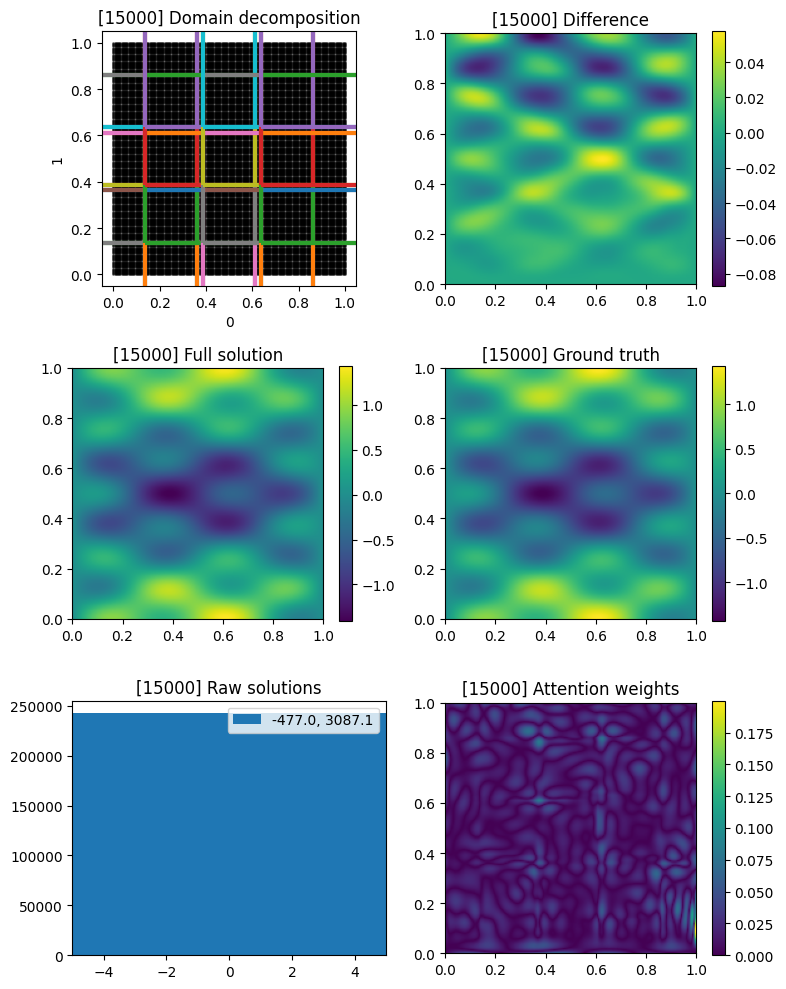

[INFO] 2025-06-07 17:05:26 - [i: 16000/25000] loss: 0.0042 rate: 12.9 elapsed: 0.35 hr test
[INFO] 2025-06-07 17:06:44 - [i: 17000/25000] loss: 0.0030 rate: 12.9 elapsed: 0.37 hr test
[INFO] 2025-06-07 17:08:01 - [i: 18000/25000] loss: 0.0023 rate: 12.9 elapsed: 0.39 hr test
[INFO] 2025-06-07 17:09:19 - [i: 19000/25000] loss: 0.0019 rate: 12.9 elapsed: 0.41 hr test
[INFO] 2025-06-07 17:10:36 - [i: 20000/25000] loss: 0.0016 rate: 12.9 elapsed: 0.43 hr test
[INFO] 2025-06-07 17:10:37 - saved arrays


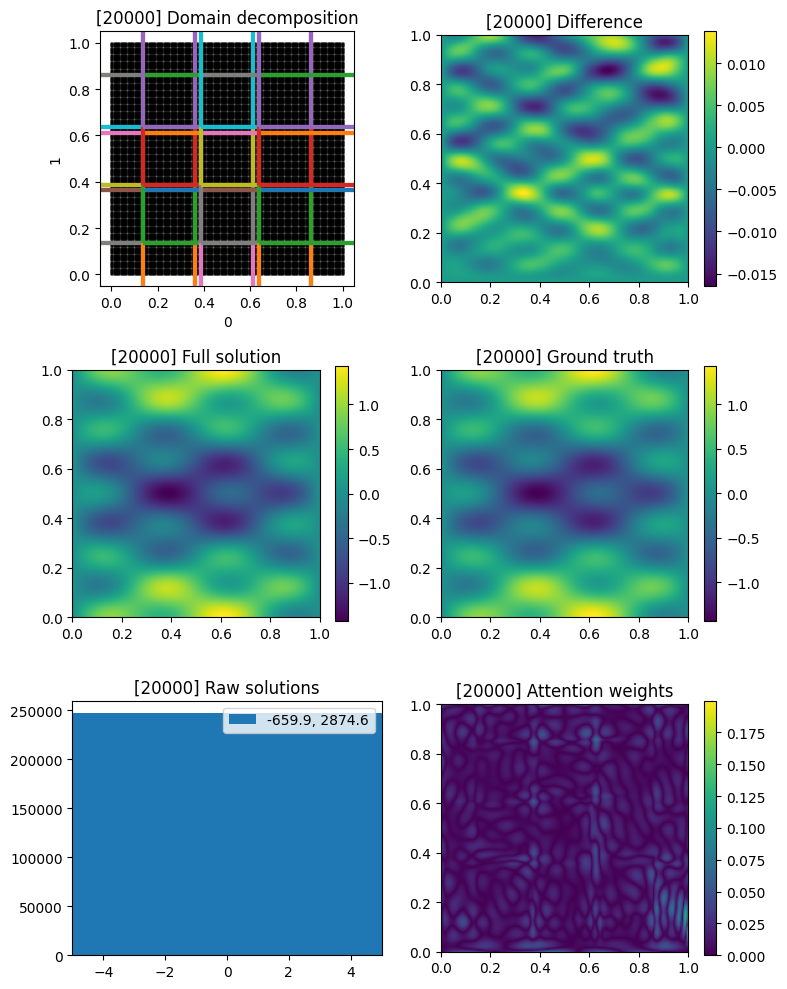

[INFO] 2025-06-07 17:11:55 - [i: 21000/25000] loss: 0.0013 rate: 12.9 elapsed: 0.46 hr test
[INFO] 2025-06-07 17:13:13 - [i: 22000/25000] loss: 0.0013 rate: 12.9 elapsed: 0.48 hr test
[INFO] 2025-06-07 17:14:31 - [i: 23000/25000] loss: 0.0010 rate: 12.9 elapsed: 0.50 hr test
[INFO] 2025-06-07 17:15:48 - [i: 24000/25000] loss: 0.0009 rate: 12.9 elapsed: 0.52 hr test
[INFO] 2025-06-07 17:17:06 - [i: 25000/25000] loss: 0.0008 rate: 12.9 elapsed: 0.54 hr test
[INFO] 2025-06-07 17:17:06 - saved arrays


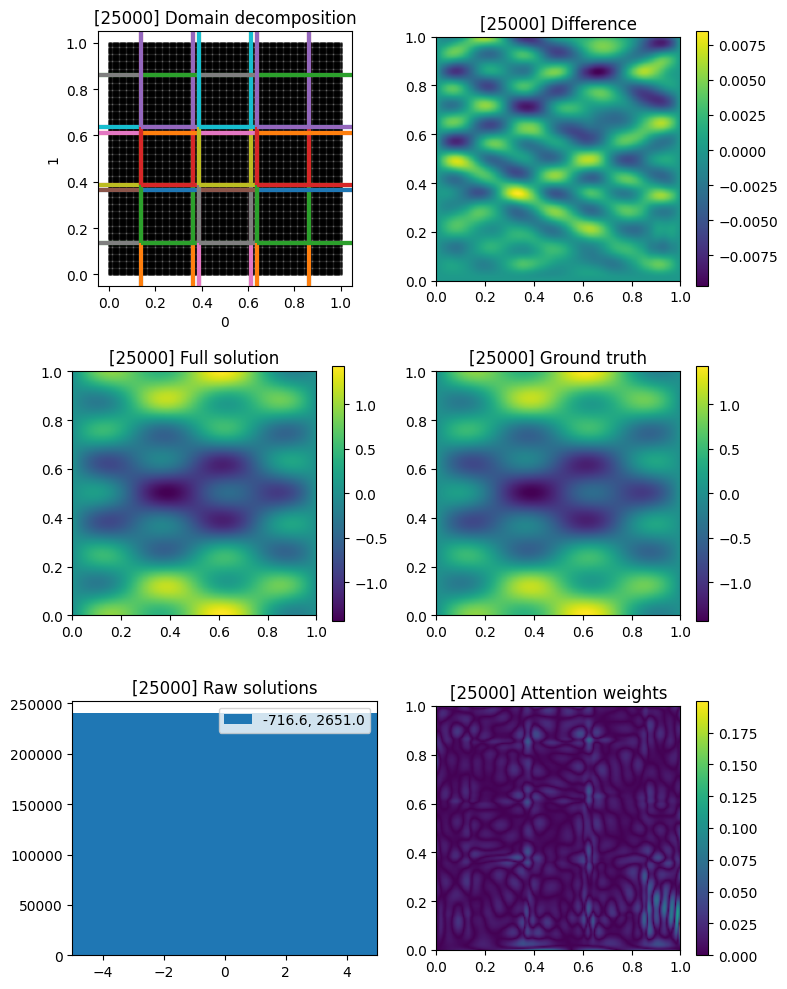

[INFO] 2025-06-07 17:17:07 - [i: 25000/25000] Training complete
[INFO] 2025-06-07 17:17:07 - [i: 25000/25000] Total training time: 1953.33 s


In [9]:
import numpy as np

from fbpinns.domains import RectangularDomainND
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN, OptimizedChebyshevKAN, ChebyshevAdaptiveKAN, OptimizedStackedChebyshevKAN, StackedChebyshevKAN_, StackedJacobiKAN_
from fbpinns.schedulers import LineSchedulerRectangularND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer
from fbpinns.attention import RBAttention

subdomain_xs=[np.linspace(0,1,5), np.linspace(0,1,5)]
c = Constants(
    domain=RectangularDomainND,
    domain_init_kwargs = dict(
        xmin=np.array([0.,0.]),
        xmax=np.array([1.,1.])
        ),
    problem=WaveEquation2DAttn,
    problem_init_kwargs = dict(
        c=2
    ),
    decomposition=RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        subdomain_xs=subdomain_xs,
        subdomain_ws=get_subdomain_ws(subdomain_xs, 2.9),
        unnorm=(0.,3.),
    ),
    # network=FCN,
    # network_init_kwargs = dict(
    #     layer_sizes = (2, 16, 16, 1),
    # ),
    network=StackedJacobiKAN_,
    network_init_kwargs=dict(
        dims=[2, 3, 1],
        degrees=[4, 4],
    ),
    # network_init_kwargs=dict(
    #     in_dim=2,
    #     out_dim=1,
    #     degree=6
    # ),
    # scheduler = LineSchedulerRectangularND,
    # scheduler_kwargs = dict(
    #     point=[0.], iaxis=0,
    # ),
    optimiser_kwargs = dict(
        learning_rate=0.001
        ),
    ns=((200,200),),
    n_test=(200,200),
    n_steps=25000,
    clear_output=False,
    attention_tracker=RBAttention,
    attention_tracking_kwargs=dict(
        eta_lr = 1e-2,
        gamma_decay = 0.95,
        shape=(40000, 1)
        ),
    )

run = FBPINNTrainer(c)
all_params = run.train()

In [8]:
all_params

({'static': {'domain': {'xd': 2,
    'xmin': Array([0., 0.], dtype=float32),
    'xmax': Array([1., 1.], dtype=float32)},
   'problem': {'dims': (1, 2),
    'c': Array(1.4142135, dtype=float32, weak_type=True),
    'sd': 0.1},
   'decomposition': {'m': 25,
    'xd': 2,
    'subdomain': {'params': [Array([[-0.3625, -0.3625],
             [-0.3625, -0.1125],
             [-0.3625,  0.1375],
             [-0.3625,  0.3875],
             [-0.3625,  0.6375],
             [-0.1125, -0.3625],
             [-0.1125, -0.1125],
             [-0.1125,  0.1375],
             [-0.1125,  0.3875],
             [-0.1125,  0.6375],
             [ 0.1375, -0.3625],
             [ 0.1375, -0.1125],
             [ 0.1375,  0.1375],
             [ 0.1375,  0.3875],
             [ 0.1375,  0.6375],
             [ 0.3875, -0.3625],
             [ 0.3875, -0.1125],
             [ 0.3875,  0.1375],
             [ 0.3875,  0.3875],
             [ 0.3875,  0.6375],
             [ 0.6375, -0.3625],
             [